* cluster head
* client_ratio
* non-IID data
* DBSCAN
* batch size
* plot

In [ ]:
import tensorflow as tf
import numpy as np
from numpy import unique
from numpy import where
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout, GlobalMaxPool2D
from tensorflow.keras import Sequential
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from sklearn.preprocessing import OneHotEncoder
import random
from itertools import accumulate

In [ ]:
# Global variablles
TOT_CLIENTS = 100
learning_rate_list = [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]
batch_size_list = [16, 32, 64, 128]
NUM_ROUNDS = 10
CLIENT_RATIO = 0.3
DATA_DIV = 5000
NUM_CLIENTS = int(TOT_CLIENTS * CLIENT_RATIO)
div_list = [np.random.randint(1000,4000) for i in range(NUM_CLIENTS)]
origin_list = [np.random.randint(0,45000) for i in range(NUM_CLIENTS)]

In [ ]:
print(np.sum(div_list))

76206


# Data Loading and Preprocessing

In [ ]:
#loading data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
print(X_train.shape)

#reshape
X_train = X_train.reshape(X_train.shape[0], 32, 32, 3)
X_test = X_test.reshape(X_test.shape[0], 32, 32, 3)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Normalixation
X_train /= 255
X_test /= 255

# One Hot encoding
ohe = OneHotEncoder(sparse=False)

y_train=ohe.fit_transform(y_train.reshape(-1, 1))
y_test=ohe.transform(y_test.reshape(-1, 1))

170500096/170498071 [==============================] - 4s 0us/step
(50000, 32, 32, 3)


In [ ]:
client_train_x = []
client_train_y = []

for i in range(NUM_CLIENTS):
  client_train_x.append(X_train[origin_list[i]:origin_list[i]+div_list[i]])
  client_train_y.append(y_train[origin_list[i]:origin_list[i]+div_list[i]])

# Model Function

In [ ]:
def create_server_model():

  model = Sequential()
  model.add(Conv2D(32, (3, 3), padding='same', activation = 'relu',input_shape = (32,32,3)))
  model.add(Conv2D(32, (3, 3), padding='same', activation = 'relu'))
  model.add(MaxPool2D((2, 2)))
  model.add(Conv2D(64, (3, 3), padding='same', activation = 'relu'))
  model.add(Conv2D(64, (3, 3), padding='same', activation = 'relu'))
  model.add(MaxPool2D((2, 2)))
  model.add(Conv2D(128, (3, 3), padding='same', activation = 'relu'))
  model.add(Conv2D(128, (3, 3), padding='same', activation = 'relu'))
  model.add(MaxPool2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(128, activation = 'relu'))
  model.add(Dense(10, activation = 'softmax'))
  return model

# Model Cloner

In [ ]:
def model_cloner(model, learning_rate, optimizer):
    new_model = tf.keras.models.clone_model(model)
    new_model.set_weights(model.get_weights())
    if optimizer=='adam':
        new_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    return new_model

# Initial Training

In [ ]:
def train_client_initial(num, model, lr_list, batch_list):
  models = []
  losses = []

  for j in range(len(batch_list)):
    for i in range(len(lr_list)):
      models.append(model_cloner(model, lr_list[i], 'adam'))
      hist = models[i].fit(client_train_x[num], client_train_y[num], epochs=1, batch_size=batch_list[j], validation_data=(X_test, y_test))
      losses.append(round(hist.history['val_loss'][0], 4))

  ind = losses.index(min(losses))

  return models[ind], lr_list[ind%3], batch_list[0 if ind < 3 else 1], losses[ind]

In [ ]:
server_model = create_server_model()
server_model.compile(optimizer = tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
server_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 128)         7

In [ ]:
lr_init = []
batches = []
losses = []
data = []
client_models = []

for j in range(NUM_CLIENTS):
  print("----------------CLIENT " + str(j) +"-------------------------")

  lr_list = np.random.choice(learning_rate_list, 3, replace=False)
  batch_list = np.random.choice(batch_size_list, 2, replace=False)
  data.append(train_client_initial(j, server_model, lr_list, batch_list))

  client_models.append(data[j][0])
  lr_init.append(data[j][1])
  batches.append(data[j][2])
  losses.append(data[j][3])

sum=[i*0 for i in client_models[0].get_weights()]
for i in range(NUM_CLIENTS):
  sum = [i+j for i, j in zip(client_models[i].get_weights(), sum)]
server_model.set_weights([i/NUM_CLIENTS for i in sum])

----------------CLIENT 0-------------------------
47/47 [==============================] - 1s 19ms/step - loss: 0.3151 - accuracy: 0.1832 - val_loss: 0.2994 - val_accuracy: 0.2497
----------------CLIENT 1-------------------------
88/88 [==============================] - 2s 23ms/step - loss: 0.3347 - accuracy: 0.0998 - val_loss: 0.3348 - val_accuracy: 0.1001
----------------CLIENT 2-------------------------
48/48 [==============================] - 1s 24ms/step - loss: 0.6923 - accuracy: 0.0950 - val_loss: 0.6906 - val_accuracy: 0.0997
----------------CLIENT 3-------------------------
16/16 [==============================] - 1s 50ms/step - loss: 0.6860 - accuracy: 0.1121 - val_loss: 0.6854 - val_accuracy: 0.1000
----------------CLIENT 4-------------------------
104/104 [==============================] - 2s 20ms/step - loss: 0.6257 - accuracy: 0.1132 - val_loss: 0.5082 - val_accuracy: 0.1000
----------------CLIENT 5-------------------------
61/61 [==============================] - 1s 19ms

In [ ]:
server_model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 2.3027 - accuracy: 0.0987


[2.3027024269104004, 0.10000000149011612]

# Clustering

In [ ]:
from sklearn.cluster import DBSCAN

batches = np.int32(np.round(2**((np.random.random([NUM_CLIENTS])*3)+4)))
lr_init = 10.0**((np.random.random([NUM_CLIENTS])*-4)-3)
lr_init1 = np.reshape(lr_init, (-1,1))
batches1 = np.reshape(batches, (-1,1))
#print(lr_init)

In [ ]:
model = DBSCAN(eps=0.15, min_samples=2)
print(np.concatenate(((np.log10(lr_init1)+3)/-4, (np.log2(batches1)-4)/3), axis=1))
yhat = model.fit_predict(np.concatenate(((np.log10(lr_init1)-3)/4, (np.log2(batches1)-4)/3), axis=1))
# retrieve unique clusters
clusters = unique(yhat)
# create scatter plot for samples from each cluster
print(yhat)

[[0.69568846 0.80875492]
 [0.54016461 0.25162917]
 [0.25779074 0.95266033]
 [0.28652048 0.72330833]
 [0.45760921 0.17452065]
 [0.13700122 0.94005965]
 [0.60224679 0.5849625 ]
 [0.10567388 0.1949875 ]
 [0.46188454 0.0826425 ]
 [0.35230021 0.95678824]
 [0.09890151 0.88607049]
 [0.2092136  1.        ]
 [0.2354596  0.89080845]
 [0.37927    0.40315112]
 [0.33928977 0.6886964 ]
 [0.73606673 0.9271199 ]
 [0.82561768 0.71658237]
 [0.89765071 0.5849625 ]
 [0.0121459  0.05664167]
 [0.03983547 0.71658237]
 [0.56858895 0.89080845]
 [0.65552396 0.36248761]
 [0.68109916 0.        ]
 [0.812996   0.48647721]
 [0.14000248 0.72994152]
 [0.84914537 0.64357911]
 [0.61788191 0.88607049]
 [0.17005203 0.25162917]
 [0.09215617 0.23347991]
 [0.59470303 0.49728437]]
[ 0  1  2  3  1  2  4  5  1  2  2  2  2 -1  3  0  6  6 -1  3  0  4 -1  6
  3  6  0  5  5  4]


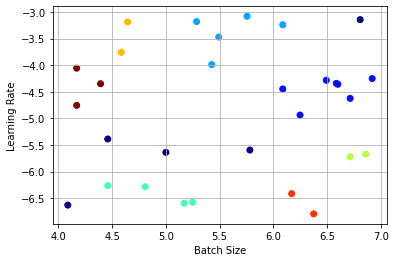

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(np.log2(batches), np.log10(lr_init), c=yhat, cmap="jet")
plt.xlabel("Batch Size")
plt.ylabel("Learning Rate")
plt.grid(True)
plt.savefig("Cluster.png", dpi=300)
plt.show()

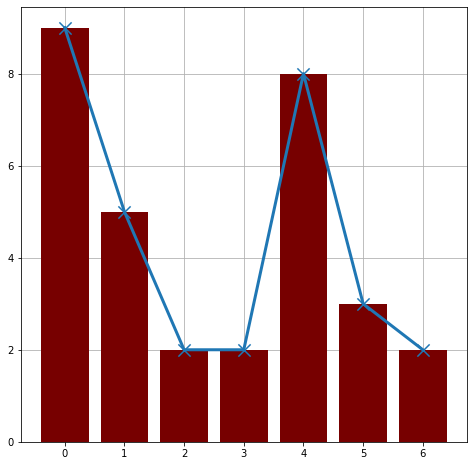

In [ ]:
t_yhat = yhat+1
clust = sorted(list(set(yhat+1)))
freq = [t_yhat[t_yhat[:]==i].shape[0] for i in clust]
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
clust = np.arange(0, 7)
freq=[9, 5, 2, 2, 8, 3, 2]
ax.bar(clust, freq, zorder=1, color="#770000")
ax.plot(clust, freq, zorder=2, linewidth=3)
ax.scatter(clust, freq, zorder=3, marker='x', s=150)
ax.set_axisbelow(True)
ax.set_xticks(clust)
plt.grid(True)
plt.savefig("bar.png", dpi=300)
plt.show()

In [ ]:
from google.colab import files
files.download("Cluster.png")
files.download("bar.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Genetic Mutation

In [ ]:
def mutate(lr):

    num = random.randint(-1,1)
    lr += (lr/10)*num

    return lr

# Genetic Mating

In [ ]:
def crossover(lrs, batches):
  new_lrs = []
  new_batches = []

  new_lrs.append(lrs[0])
  new_batches.append(batches[0])
  if(len(lrs) >1):
    new_lrs.append(lrs[1])
    new_batches.append(batches[1])

  if(len(lrs) > 2):
    for i in range(2, len(lrs)):
      # parentA = random.randint(0, len(lrs)-1)
      # parentB = random.randint(0, len(lrs)-1)

      # num = np.random.choice([parentA, parentB])
      # num2 = parentA if num == parentB else parentB
      new_lrs.append(mutate(lrs[random.randint(0, len(lrs)-1)]))
      new_batches.append(batches[random.randint(0, len(batches)-1)])


  return new_lrs, new_batches

# Genetic Evolution

In [ ]:
def evolve(losses, lrs, batches):
    sorted_y_idx_list = sorted(range(len(losses)),key=lambda x:losses[x])
    lrs = [lrs[i] for i in sorted_y_idx_list]
    batches = [batches[i] for i in sorted_y_idx_list]
    lrs, batches = crossover(lrs, batches)

    return lrs, batches

# Edge Device training

In [ ]:
def train_client(num, model, lr, batch):

  new_model = model_cloner(model, lr, 'adam')
  hist = model.fit(client_train_x[num], client_train_y[num], epochs=2, batch_size=batch, validation_data=(X_test, y_test))

  return new_model, lr, round(hist.history['val_loss'][-1], 4), batch


In [ ]:
losses 

[0.2754,
 0.3094,
 0.2609,
 0.3261,
 0.3016,
 0.2605,
 0.2825,
 0.2886,
 0.3018,
 0.3197,
 0.2867,
 0.3255,
 0.2944,
 0.3003,
 0.3269,
 0.3222,
 0.3268,
 0.3288,
 0.3255,
 0.3275,
 0.3239,
 0.3306,
 0.327,
 0.3254,
 0.3143,
 0.3214,
 0.3258,
 0.2942,
 0.3117,
 0.3301]

In [ ]:
lr_init 

array([1.97145754e-07, 4.62420842e-06, 3.35551851e-05, 2.29753384e-06,
       1.01735740e-07, 7.08797848e-05, 5.24905468e-05, 3.35534081e-05,
       4.19695594e-04, 9.36806673e-04, 8.25264914e-04, 2.25170441e-04,
       1.15956746e-04, 6.89400491e-06, 4.33920608e-05, 3.96124178e-07,
       2.89568558e-06, 1.09272270e-07, 1.44513764e-05, 2.02552672e-05,
       1.44546011e-05, 3.68926822e-07, 1.52183388e-04, 2.12903856e-07,
       5.53088120e-06, 3.62099971e-07, 4.03157435e-05, 7.02352621e-07,
       8.64159785e-04, 6.49323023e-04])

In [ ]:
batches1

array([[ 59],
       [ 31],
       [ 35],
       [ 38],
       [ 16],
       [ 54],
       [ 70],
       [ 32],
       [ 19],
       [ 34],
       [ 19],
       [ 67],
       [ 25],
       [ 43],
       [ 86],
       [ 17],
       [ 40],
       [ 28],
       [ 18],
       [ 71],
       [ 49],
       [ 51],
       [ 16],
       [ 26],
       [ 39],
       [121],
       [ 34],
       [ 16],
       [ 84],
       [ 38]], dtype=int32)

In [ ]:
yhat
if(-1 in yhat):
  flag=1
else:
  flag=0

# Genetic Clustering FL

In [ ]:
yhat = list(yhat)
serverhist1={
    "loss": list(),
    "accuracy": list()
}
# Control loop
for i in range(NUM_ROUNDS):
  print("---------"+str(i)+"------------")
  lr_global = []
  batch_global = []
  data = []
  #  Genetic Optimization of Hyper-Parameters
  for cluster in clusters:
    ind = [k for k in range(len(yhat)) if(yhat[k]==cluster)]
    #print(ind)
    #print(losses)
    #print(lr_init)
    #print(batches)
    data.append(evolve([losses[k] for k in ind], [lr_init[k] for k in ind], [batches[k] for k in ind]))
    lr_global.append(data[-1][0])
    batch_global.append(data[-1][1])
    

  lr_init = []
  batches = []
  losses = []
  data = []
  lrid = np.zeros(len(clusters)) # lrid=[2,1,0]
  for j in range(NUM_CLIENTS):
    print(lrid)
    # SHAASHWAT AGRAWAL FACT CHECK THE LOGIC HERE lr_global[cluster][clusteri - current index]
    data.append(train_client(j, server_model, lr_global[yhat[j]+flag][int(lrid[yhat[j]+flag])], batch_global[yhat[j]+flag][int(lrid[yhat[j]+flag])]))
    lrid[yhat[j]+flag] +=1

    client_models[j] = data[j][0]
    losses.append(data[j][2])
    lr_init.append(data[j][1])
    batches.append(data[j][3])

  '''# Cluster head aggregation
  n_clust = len(set(yhat))
  a = [[i*0 for i in client_models[0].get_weights()] for i in range(n_clust)]
  for i in range(len(yhat)):
    a[yhat[i]] = [k+j for k, j in zip(client_models[i].get_weights(), a[yhat[i]])]'''


  # Aggregating model
  sum=[i*0 for i in client_models[0].get_weights()]
  for i in range(NUM_CLIENTS):
    sum = [i+j for i, j in zip(client_models[i].get_weights(), sum)]
  server_model.set_weights([i/NUM_CLIENTS for i in sum])

  # Model Evaluation
  h=server_model.evaluate(X_test,y_test)
  serverhist1['loss'].append(h[1])
  serverhist1['accuracy'].append(h[0])

---------0------------
[0. 0. 0. 0. 0. 0. 0.]
Epoch 1/2
43/43 [==============================] - 2s 24ms/step - loss: 2.2523 - accuracy: 0.1373 - val_loss: 2.1079 - val_accuracy: 0.2087
Epoch 2/2
43/43 [==============================] - 1s 21ms/step - loss: 1.9747 - accuracy: 0.2690 - val_loss: 1.9108 - val_accuracy: 0.2922
[1. 0. 0. 0. 0. 0. 0.]
Epoch 1/2
54/54 [==============================] - 1s 24ms/step - loss: 1.8687 - accuracy: 0.3104 - val_loss: 1.9740 - val_accuracy: 0.2760
Epoch 2/2
54/54 [==============================] - 1s 19ms/step - loss: 1.7363 - accuracy: 0.3553 - val_loss: 1.6650 - val_accuracy: 0.3843
[1. 1. 0. 0. 0. 0. 0.]
Epoch 1/2
114/114 [==============================] - 2s 16ms/step - loss: 1.6983 - accuracy: 0.3709 - val_loss: 1.7016 - val_accuracy: 0.3646
Epoch 2/2
114/114 [==============================] - 2s 15ms/step - loss: 1.5760 - accuracy: 0.4229 - val_loss: 1.4848 - val_accuracy: 0.4586
[1. 2. 0. 0. 0. 0. 0.]
Epoch 1/2
20/20 [========================

In [ ]:
len(batches)

30

In [ ]:
batch_global

[[59, 51],
 [86, 86, 86, 25, 86, 86, 19, 86, 86, 86, 25, 86, 86, 86, 86, 86, 86, 70, 86],
 [16, 16, 16],
 [38, 34],
 [28, 26],
 [18],
 [121]]

In [ ]:
data

[(<tensorflow.python.keras.engine.sequential.Sequential at 0x7f1724d8a1d0>,
  1.9714575439424883e-07,
  1.377,
  59),
 (<tensorflow.python.keras.engine.sequential.Sequential at 0x7f1724f8a450>,
  4.532186668506956e-06,
  1.433,
  86),
 (<tensorflow.python.keras.engine.sequential.Sequential at 0x7f170a4cf7d0>,
  5.4839458688934165e-06,
  1.5909,
  86),
 (<tensorflow.python.keras.engine.sequential.Sequential at 0x7f17a20a6c50>,
  5.962898333850164e-06,
  1.5629,
  86),
 (<tensorflow.python.keras.engine.sequential.Sequential at 0x7f170a2fbb10>,
  6.953290948085145e-07,
  1.6503,
  16),
 (<tensorflow.python.keras.engine.sequential.Sequential at 0x7f1724f0ad90>,
  4.985405335357651e-06,
  1.6974,
  25),
 (<tensorflow.python.keras.engine.sequential.Sequential at 0x7f17248e4f50>,
  5.035762965007729e-06,
  1.581,
  86),
 (<tensorflow.python.keras.engine.sequential.Sequential at 0x7f17248b6050>,
  5.4839458688934165e-06,
  1.598,
  86),
 (<tensorflow.python.keras.engine.sequential.Sequential a

In [ ]:
server_model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 1.1962 - accuracy: 0.7624


[1.1961537599563599, 0.7623999714851379]

# Generic FL

In [ ]:
client_models = [0]*NUM_CLIENTS
client_models

server_model_norm = create_server_model()
server_model_norm.compile(optimizer = tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
serverhist={
    "loss":[],
    "accuracy":[]
}

for i in range(NUM_ROUNDS):
  print("-----"+str(i)+"---------")
  losses = []
  lr_init = []
  data= []
  for j in range(NUM_CLIENTS):
    data.append(train_client(j, server_model_norm, 0.0001, 32))

    client_models[j] = data[j][0]
    losses.append(data[j][2])
    lr_init.append(data[j][1])

  # Aggregating model
  sum=[i*0 for i in client_models[0].get_weights()]
  for i in range(NUM_CLIENTS):
    sum = [i+j for i, j in zip(client_models[i].get_weights(), sum)]
  server_model_norm.set_weights([i/NUM_CLIENTS for i in sum])
  h=server_model_norm.evaluate(X_test,y_test)
  serverhist['loss'].append(h[1])
  serverhist['accuracy'].append(h[0])

-----0---------
Epoch 1/2
79/79 [==============================] - 2s 23ms/step - loss: 2.2785 - accuracy: 0.1234 - val_loss: 1.9972 - val_accuracy: 0.2563
Epoch 2/2
79/79 [==============================] - 1s 19ms/step - loss: 1.9821 - accuracy: 0.2792 - val_loss: 1.8405 - val_accuracy: 0.3395
Epoch 1/2
91/91 [==============================] - 2s 18ms/step - loss: 1.8440 - accuracy: 0.3242 - val_loss: 1.6721 - val_accuracy: 0.3890
Epoch 2/2
91/91 [==============================] - 2s 17ms/step - loss: 1.6805 - accuracy: 0.3885 - val_loss: 1.5928 - val_accuracy: 0.4185
Epoch 1/2
124/124 [==============================] - 2s 15ms/step - loss: 1.6164 - accuracy: 0.4022 - val_loss: 1.5433 - val_accuracy: 0.4289
Epoch 2/2
124/124 [==============================] - 2s 14ms/step - loss: 1.4705 - accuracy: 0.4601 - val_loss: 1.4272 - val_accuracy: 0.4815
Epoch 1/2
54/54 [==============================] - 1s 27ms/step - loss: 1.4907 - accuracy: 0.4680 - val_loss: 1.3883 - val_accuracy: 0.4933


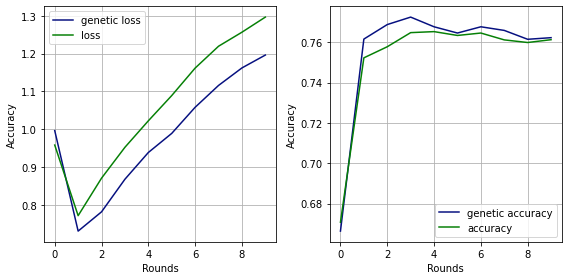

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 4))
ax=fig.add_subplot(121)
ax.plot([0.9964, 0.7309, 0.7818, 0.8680, 0.9386, 0.9891, 1.0581, 1.1158, 1.1621, 1.1961], label="genetic loss", color="#061080")
ax.plot([0.9583, 0.7717, 0.8708, 0.9524, 1.0223, 1.0891, 1.1617, 1.2194, 1.2565, 1.2964], label="loss", color="#068006")
ax.legend()
ax.grid(True)
ax.set_xlabel("Rounds")
ax.set_ylabel("Accuracy")
ax=fig.add_subplot(122)
ax.plot([0.6664, 0.7616, 0.7688, 0.7725, 0.7677, 0.7646, 0.7677, 0.7659, 0.7615, 0.7623], label="genetic accuracy", color="#061080")
ax.plot([0.6708, 0.7523, 0.7578, 0.7648, 0.7653, 0.7634, 0.7646, 0.7612, 0.7599, 0.7613], label="accuracy", color="#068006")
ax.legend()
ax.grid(True)
ax.set_xlabel("Rounds")
ax.set_ylabel("Accuracy")
plt.tight_layout()
plt.savefig("Generic_FL.png", dpi=300)
plt.show()

In [ ]:
print(" \t\t\tGenetic CFL\t\t\t\tFL")
print("Round\tAccuracy\t\tLoss\t\t\tAccuracy\t\tLoss")
for i in range(NUM_ROUNDS):
  print(str(i+1)+"\t"+str(serverhist1['loss'][i])+"\t"+str(serverhist1['accuracy'][i])+"\t"+str(serverhist['loss'][i])+"\t"+str(serverhist['accuracy'][i]))

 			Genetic CFL				FL
Round	Accuracy		Loss			Accuracy		Loss
1	0.6664000153541565	0.996465802192688	0.6708999872207642	0.9583895802497864
2	0.7616999745368958	0.7309398651123047	0.7523000240325928	0.7717142105102539
3	0.7688000202178955	0.781869649887085	0.7578999996185303	0.8708730340003967
4	0.772599995136261	0.8680950999259949	0.7648000121116638	0.9524703025817871
5	0.767799973487854	0.9386677742004395	0.7653999924659729	1.0223759412765503
6	0.7646999955177307	0.9891061782836914	0.7634000182151794	1.0891839265823364
7	0.767799973487854	1.058154821395874	0.7646999955177307	1.1617337465286255
8	0.7659000158309937	1.1158766746520996	0.7612000107765198	1.2194958925247192
9	0.7615000009536743	1.1621036529541016	0.7599999904632568	1.25657320022583
10	0.7623999714851379	1.1961537599563599	0.7613999843597412	1.2964723110198975


In [ ]:
from google.colab import files
files.download("Generic_FL.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Normal Training

In [ ]:
server_model_norm = create_server_model()
num=0
server_model_norm.compile(optimizer = tf.keras.optimizers.Adam(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
n_hist = server_model_norm.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
1563/1563 [==============================] - 11s 7ms/step - loss: 1.8696 - accuracy: 0.3064 - val_loss: 1.3973 - val_accuracy: 0.4902
Epoch 2/10
1563/1563 [==============================] - 10s 6ms/step - loss: 1.3594 - accuracy: 0.5095 - val_loss: 1.2043 - val_accuracy: 0.5604
Epoch 3/10
1563/1563 [==============================] - 10s 6ms/step - loss: 1.1601 - accuracy: 0.5931 - val_loss: 1.0883 - val_accuracy: 0.6133
Epoch 4/10
1563/1563 [==============================] - 10s 6ms/step - loss: 1.0369 - accuracy: 0.6346 - val_loss: 1.0070 - val_accuracy: 0.6432
Epoch 5/10
1563/1563 [==============================] - 10s 6ms/step - loss: 0.9610 - accuracy: 0.6632 - val_loss: 0.9429 - val_accuracy: 0.6672
Epoch 6/10
1563/1563 [==============================] - 10s 6ms/step - loss: 0.8630 - accuracy: 0.7017 - val_loss: 0.8814 - val_accuracy: 0.6950
Epoch 7/10
1563/1563 [==============================] - 10s 6ms/step - loss: 0.7978 - accuracy: 0.7233 - val_loss: 0.8414 - val_ac

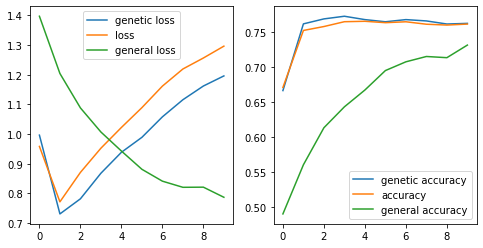

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 4))
ax=fig.add_subplot(121)
ax.plot(serverhist1['accuracy'], label="genetic loss")
ax.plot(serverhist['accuracy'], label="loss")
ax.plot(n_hist.history['val_loss'], label="general loss")
ax.legend()
ax=fig.add_subplot(122)
ax.plot(serverhist1['loss'], label="genetic accuracy")
ax.plot(serverhist['loss'], label="accuracy")
ax.plot(n_hist.history['val_accuracy'], label="general accuracy")
ax.legend()
plt.savefig("Generic FL", dpi=300)
plt.show()